In [220]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import permutations
import numpy as np
from scipy.special import logsumexp
from matplotlib import pyplot as plt
import scipy.stats as spst

np.random.seed(60)

In [235]:
import warnings
warnings.filterwarnings("ignore")

In [221]:
def get_transitions_utilities(pos):
    transition_team = np.loadtxt(f"transitions/aggregate/team/{pos}_team_matrix.csv", delimiter=",")
    transition_trade_tierbased = np.loadtxt(f"transitions/aggregate/trade/{pos}_trade_matrix.csv", delimiter=",")
    reward_team = pd.read_csv(f"rewards/team/reward_notrade_{pos}.csv", index_col=0)
    reward_trade = pd.read_csv(f"rewards/trade/reward_trade_{pos}.csv", index_col=0)

    # build utility matrix (states x choices) = (4000 * 2) 
    # rows: (0,A), (0, B) ... (999, C), (999, D)
    # columns: [team, trade]
    utilities = np.zeros((4000, 2))
    trade_util_tiled = np.tile(reward_trade.METRIC.values, 1000)
    utilities[:, 0] = reward_team.ADJ_METRIC.values.flatten()
    utilities[:, 1] = trade_util_tiled

    # build transition matrix choices x (states x states) = 2 x (4000 * 4000) 
    # index 1: [team, trade]
    # index 2: transition matrix
    # for trade, notice that the large transition matrix is the same tiered matrix tiled 1000 times 
    # this is because from any initial tenure the tenure goes necessarily to 0 for trade

    transition_trade = np.zeros((4000, 4000))
    transition_trade_tierbased_tiled = np.tile(transition_trade_tierbased.flatten(), 1000).reshape(-1, 4)
    transition_trade[:, 0:4] = transition_trade_tierbased_tiled

    transitions = np.array([transition_team, transition_trade])

    #check
    # assert sum(np.sum(transition_team, axis=1)) == 1000
    # assert sum(np.sum(transition_trade, axis=1)) == 1000 
    # assert transitions.shape == (2, 4000, 4000)
    # assert utilities.shape == (4000, 2)

    return transitions, utilities

In [222]:
def run_pompdp(pos):
    beta = 0.7

    states = 4000
    choices = 2

    transitions, utilities = get_transitions_utilities(pos)

    # discount factor and convergence threshold
    tol = 1e-8
    EV = np.zeros((states, choices))
    norms = []

    while True:
        EVnew = np.empty((states, choices))
        ## Update the EV function. By the end of this part, you should generate the values for EVnew,
        ## Which is the updated EV.

        ## You will find logsumexp function handy
        ########################
        lse = logsumexp(utilities+beta*EV, axis=1)
        ## for a in range(choices):
            ##EVnew[:,a] = transitions[a]@ lse  

        EVnew= (transitions@ lse).T  
        ########################
        # convergence criterion
        improvement = np.linalg.norm(EVnew-EV)
        norms.append(improvement)
        if improvement<tol:
            EV = EVnew  
            break 
        else:
            EV = EVnew

    return EV

In [223]:
position_EVs = {}
for pos in ["PG", "SG", "SF", "PF", "C"]:
    position_EVs[pos] = run_pompdp(pos)

In [270]:
position_utilities = {}
for pos in ["PG", "SG", "SF", "PF", "C"]:
    _, position_utilities[pos] = get_transitions_utilities(pos)

In [224]:
def plot_EV_team_by_tenure(pos, tier, ax, color, save=False):
    """
    Plot the EV by tenure if the player is kept on the team
    """
    EV = position_EVs[pos]

    tiers = ["A", "B", "C", "D"]
    results = EV[tiers.index(tier)::4, 0] #keep on team

    ax.plot(np.arange(1, 1001), results, color=color)
    ax.set_xlabel("Tenure")
    ax.set_ylabel("EV")
    ax.set_ylim(1,12)
    ax.set_xlim(0,700)
    ax.set_title("EV by Tenure, {pos}, Tier {tier}".format(pos=pos, tier=tier))
    
    if save:
        plt.savefig(f"plots/single_ev_by_tenure_team/ev_by_tenure_{pos}_{tier}.png")


In [225]:
def plot_EV_team_4by4(pos, save=False):

    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(15, 10)
    plot_EV_team_by_tenure(pos, "A", ax[0][0], "green")
    plot_EV_team_by_tenure(pos, "B", ax[0][1], "orange")
    plot_EV_team_by_tenure(pos, "C", ax[1][0], "coral")
    plot_EV_team_by_tenure(pos, "D", ax[1][1], "black")

    if save:
        plt.savefig(f"plots/mult_ev_by_tenure_team/ev_by_tenure_{pos}.png")

    plt.show()


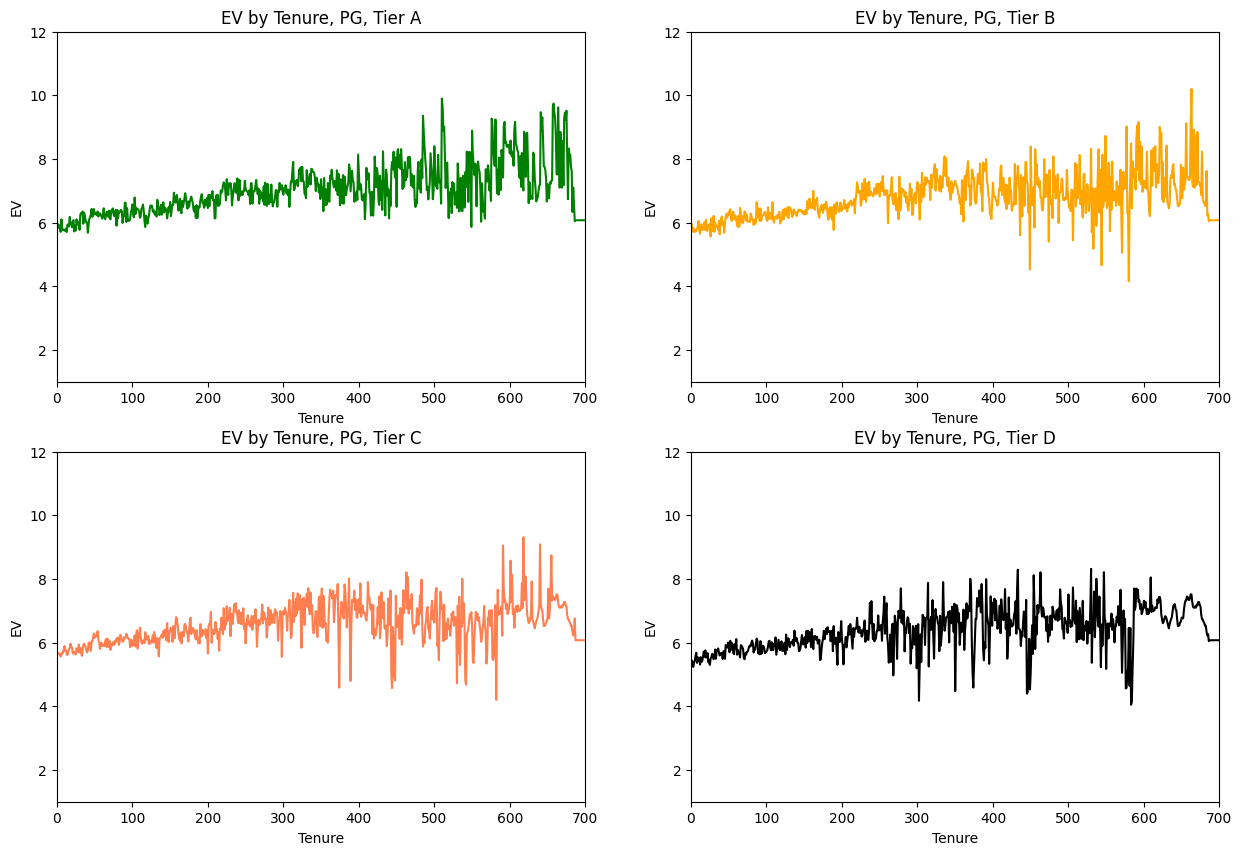

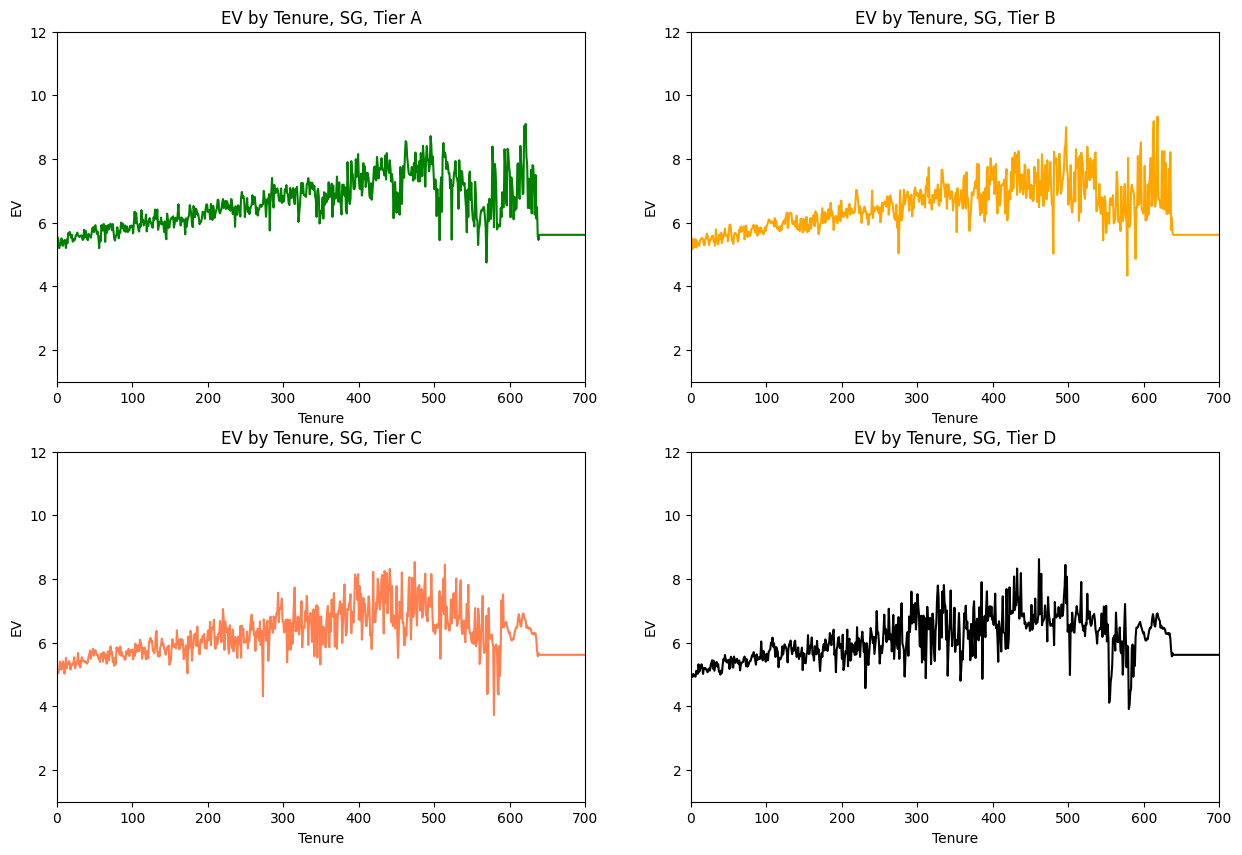

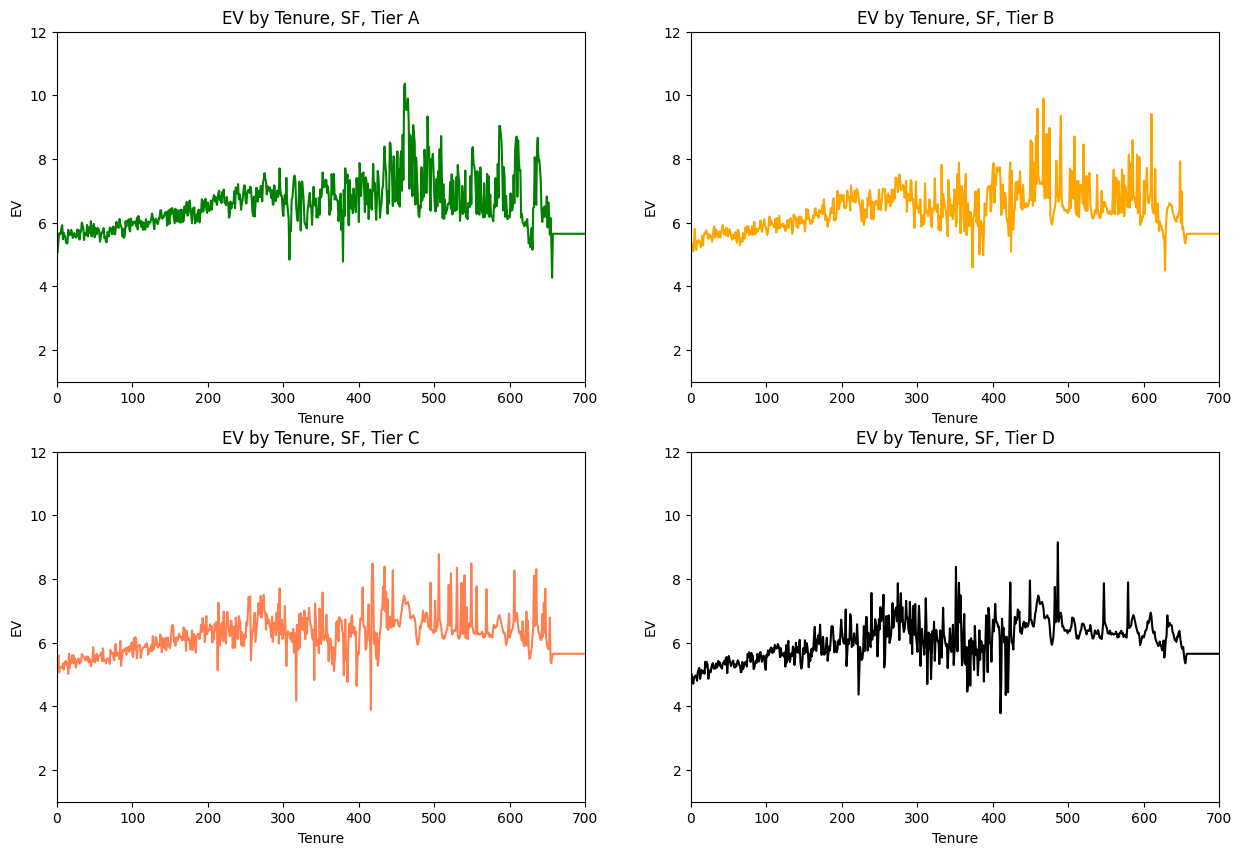

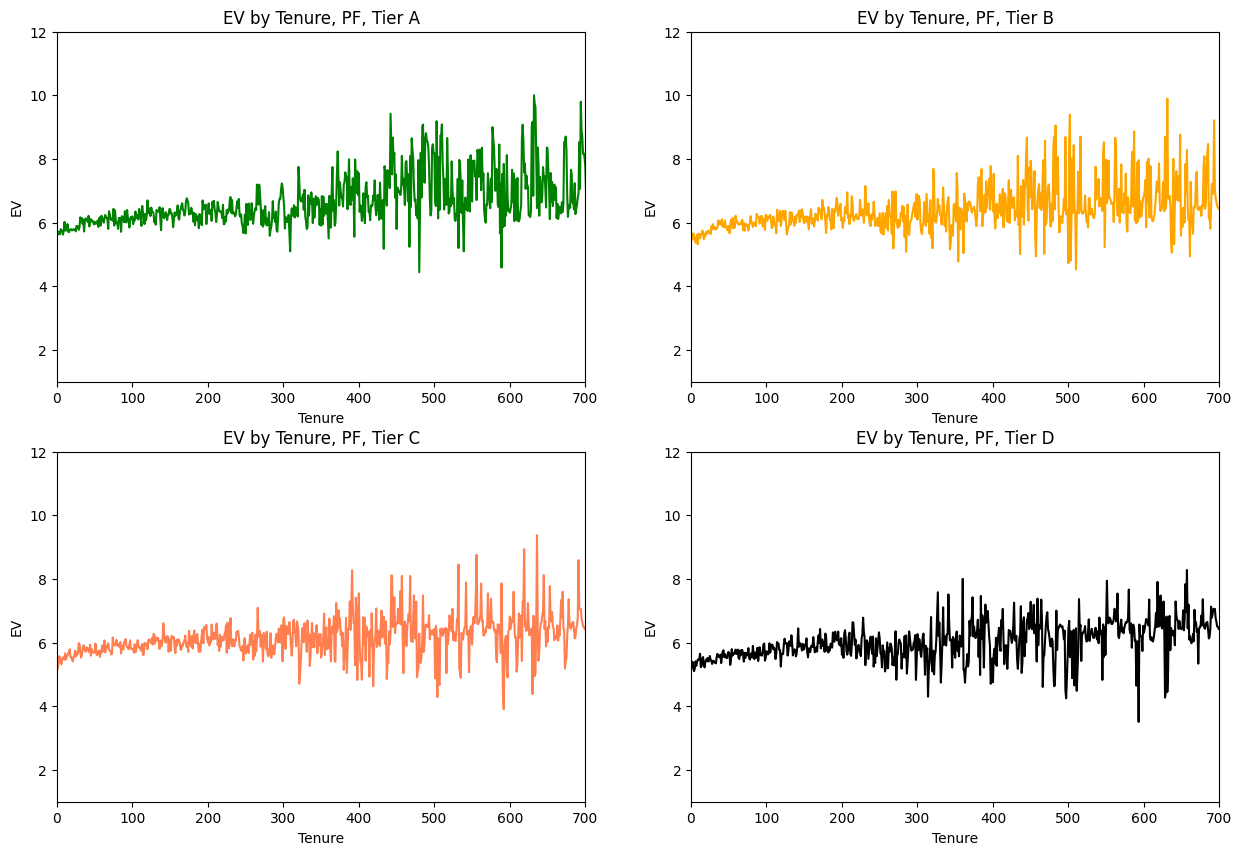

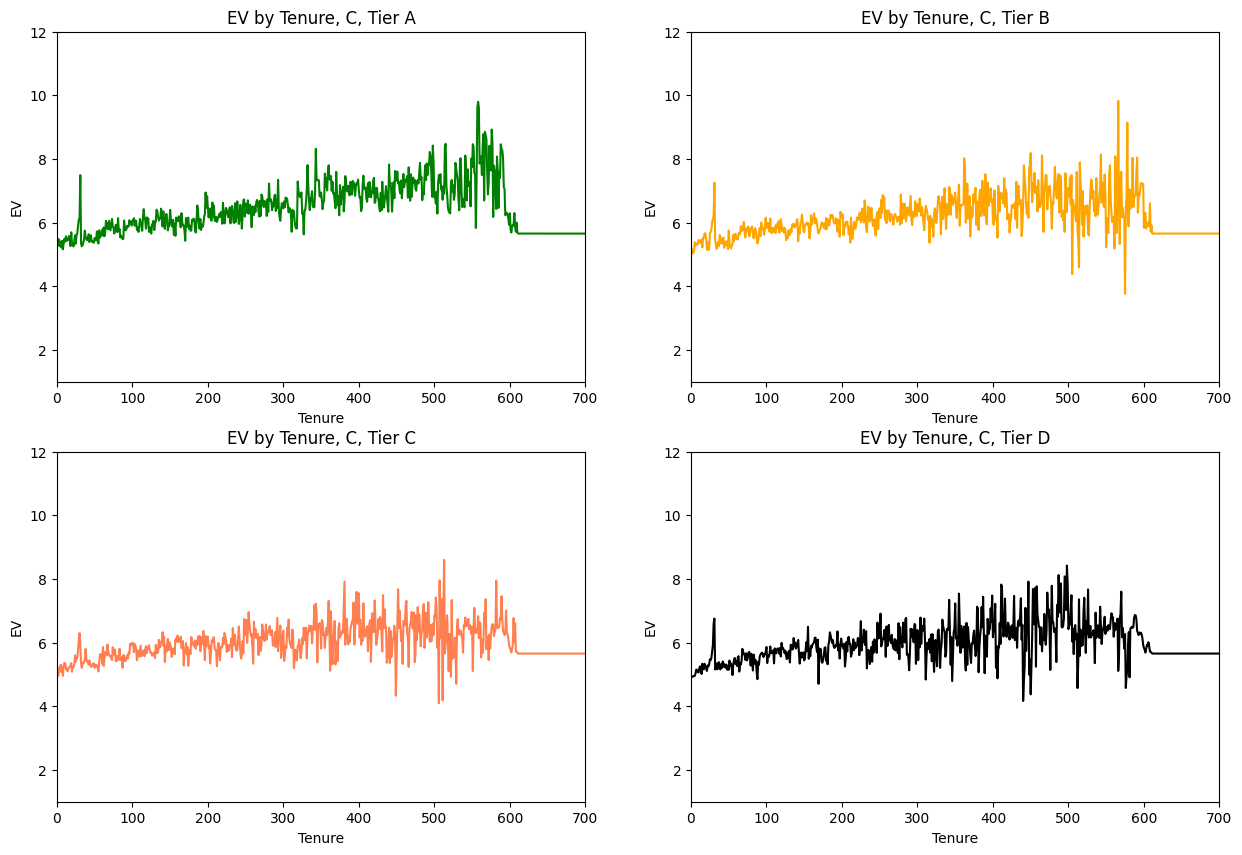

In [226]:
for pos in ["PG", "SG", "SF", "PF", "C"]:
    plot_EV_team_4by4(pos, save=True)

<h2>Choice Probabilities</h2>

In [227]:
def plot_EV_trade_by_tenure(pos, ax, save=False):
    """
    Plot the EV by tenure if the player is kept on the team
    """
    EV = position_EVs[pos]

    tiers  = ["A", "B", "C", "D"]
    heights = []

    for tier in tiers:
        results = EV[tiers.index(tier)::4, 1] #keep on team
        heights.append(results.mean())

    ax.bar(tiers, heights, label=tiers, width=0.5)
    ax.set_xlabel("Tier")
    ax.set_ylabel("EV")

    ax.set_title("EV for Trade by Tier, {pos}".format(pos=pos, tier=tier))
    
    if save:
        plt.savefig(f"plots/ev_by_pos_trade/ev_trade_{pos}.png")


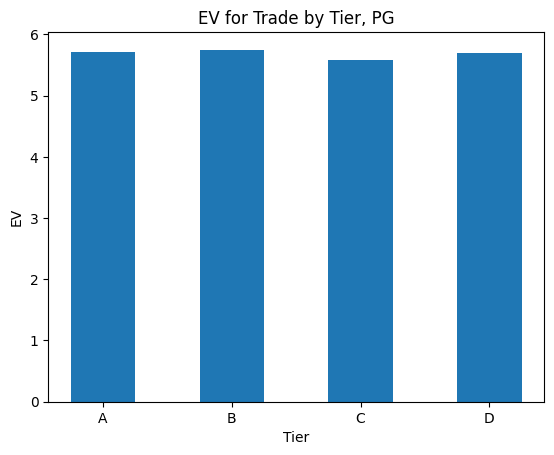

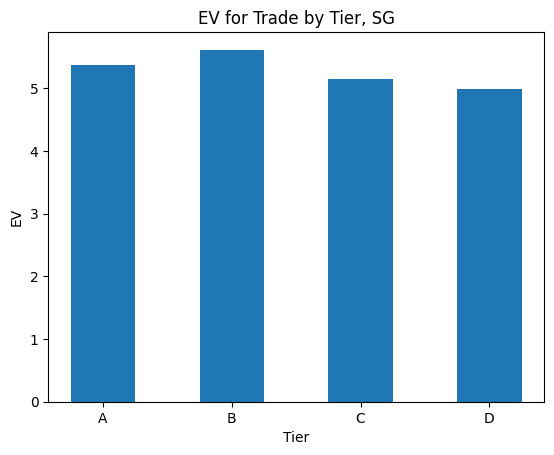

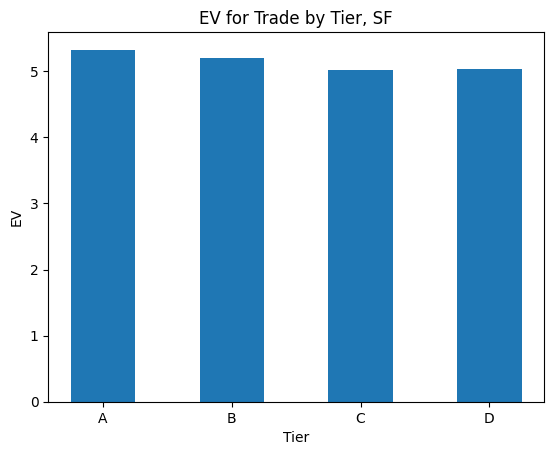

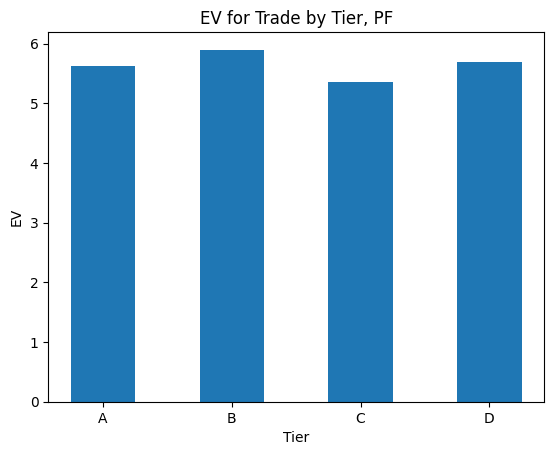

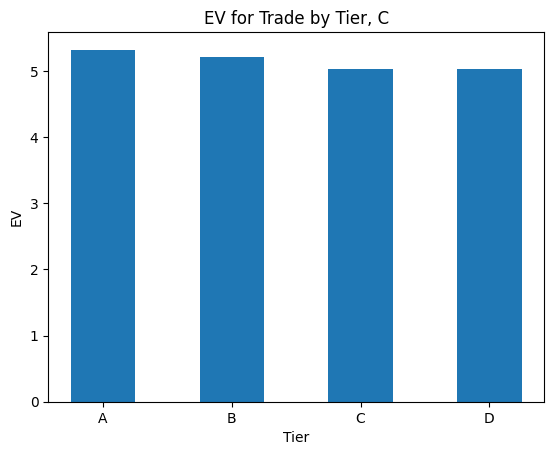

In [228]:
for pos in ["PG", "SG", "SF", "PF", "C"]:
    fig, ax = plt.subplots()
    plot_EV_trade_by_tenure(pos, ax, save=True)
    plt.show()

In [229]:
SAMPLE = False
if SAMPLE:
    # generate the filenames for basketball positions
    filenames = ["data/sample_aggregate/C_sample_aggregate.csv", 
                 "data/sample_aggregate/PF_sample_aggregate.csv", 
                 "data/sample_aggregate/PG_sample_aggregate.csv",
                 "data/sample_aggregate/SF_sample_aggregate.csv",
                 "data/sample_aggregate/SG_sample_aggregate.csv"]
else:
    filenames = ["data/aggregate/C_aggregate.csv",
                 "data/aggregate/PF_aggregate.csv",
                 "data/aggregate/PG_aggregate.csv",
                 "data/aggregate/SF_aggregate.csv",
                 "data/aggregate/SG_aggregate.csv"]

In [230]:
positions = ["C", "PF", "PG", "SF", "SG"]
position_dfs = defaultdict(pd.DataFrame)
for i, filename in enumerate(filenames):
    position_dfs[positions[i]] = pd.read_csv(filename, index_col=0)

pos_bins = defaultdict(list)
for pos in positions:
    position_dfs[pos]["METRIC"] = position_dfs[pos]["METRIC"].astype(float)
    position_dfs[pos]["TIER"], bins = pd.qcut(position_dfs[pos]["METRIC"], 4, labels=["D", "C", "B", "A"], retbins=True)
    pos_bins[pos] = bins

,PLAYER_NAME,PLAYER_ID,TEAM_NAME,TEAM_ABBREVIATION,GAME_DATE,MATCHUP,METRIC,TIER,TENURE
15676,James Harden,201935,Houston Rockets,HOU,2013-10-30T00:00:00,HOU vs. CHA,2.147741,B,0
15677,James Harden,201935,Houston Rockets,HOU,2013-11-01T00:00:00,HOU vs. DAL,2.802806,A,1
15678,James Harden,201935,Houston Rockets,HOU,2013-11-02T00:00:00,HOU @ UTA,1.964936,B,2
15679,James Harden,201935,Houston Rockets,HOU,2013-11-04T00:00:00,HOU @ LAC,1.401829,C,3
15680,James Harden,201935,Houston Rockets,HOU,2013-11-05T00:00:00,HOU @ POR,2.428951,A,4
...,...,...,...,...,...,...,...,...,...
16373,James Harden,201935,Philadelphia 76ers,PHI,2023-03-29T00:00:00,PHI vs. DAL,1.906664,B,74
16374,James Harden,201935,Philadelphia 76ers,PHI,2023-03-31T00:00:00,PHI vs. TOR,2.951625,A,75
16375,James Harden,201935,Philadelphia 76ers,PHI,2023-04-02T00:00:00,PHI @ MIL,2.039391,B,76
16376,James Harden,201935,Philadelphia 76ers,PHI,2023-04-04T00:00:00,PHI vs. BOS,2.655667,A,77


In [331]:
def get_choice_prob_analysis(pos, player_name):
    player_df = position_dfs[pos].loc[position_dfs[pos].PLAYER_NAME == player_name, :]
    player_df['TENURE'] = (player_df[['PLAYER_NAME', 'TEAM_NAME']] != player_df[['PLAYER_NAME', 'TEAM_NAME']].shift()).any(axis=1).cumsum() - 1
    changes = (player_df[['PLAYER_NAME', 'TEAM_NAME']] != player_df[['PLAYER_NAME', 'TEAM_NAME']].shift()).any(axis=1)
    player_df['TENURE'] = player_df.groupby(changes.cumsum())['TENURE'].cumcount()

    player_df["STATE"] = list(zip(player_df["TENURE"], player_df["TIER"]))

    tenures = np.arange(0,1000)
    count_matrix_index = pd.MultiIndex.from_product([tenures, ["A", "B", "C", "D"]])

    beta = 0.7
    util_EV = player_df.apply(lambda x: position_utilities[pos][count_matrix_index.get_loc(x.STATE)] + beta*position_EVs[pos][count_matrix_index.get_loc(x.STATE)], axis=1).apply(pd.Series).values

    choice_probs = np.exp(util_EV)/(np.exp(util_EV).sum(axis=1).reshape(-1,1))


    player_df["LAG_TEAM"] = player_df["TEAM_NAME"].shift() 
    player_df = player_df.dropna()
    trade_occurences = player_df.loc[player_df.loc[player_df["LAG_TEAM"] != player_df["TEAM_NAME"]].index-1, :].TENURE.sort_values()

    return choice_probs, trade_occurences

In [332]:
def plot_choice_prob_analysis(choice_probs, trade_occurences, player_name, save=False):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    ax.plot(np.arange(1, len(choice_probs)+1), choice_probs[:, 1])
    for i, trade_occurence in enumerate(trade_occurences):
        ax.axvline(x = trade_occurence, color = 'red', label = 'Actual Trade Occurence' if i == 0 else None)
    ax.set_title(f"Probability of Choosing to Trade, {player_name}")
    ax.set_xlabel("Tenure")
    ax.set_ylabel("Probability")
    ax.legend(loc='upper left')
    plt.gcf()

    if save:
        savename = player_name.replace(" ", "")
        plt.savefig(f"plots/choice_prob_analysis/choice_prob_{savename}.png")
    
    plt.show()


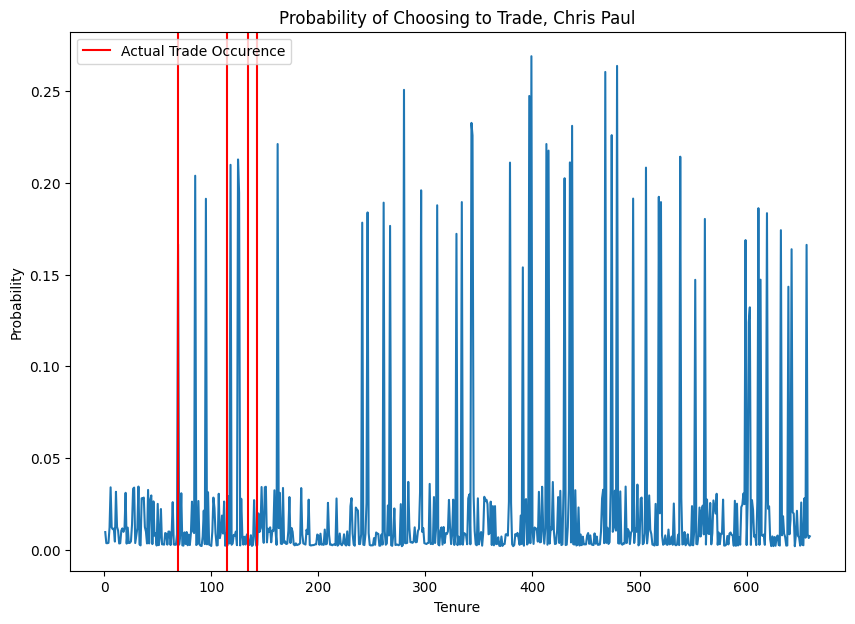

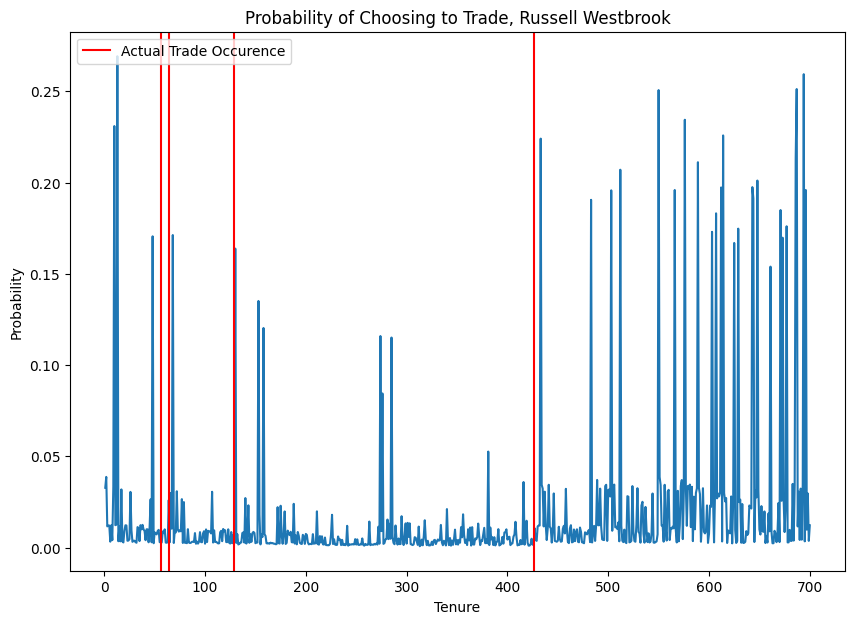

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


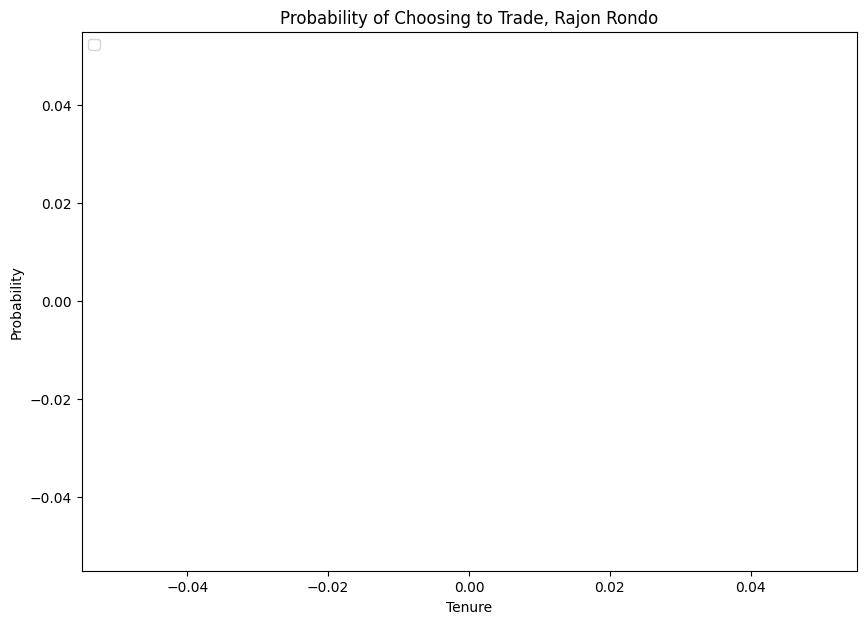

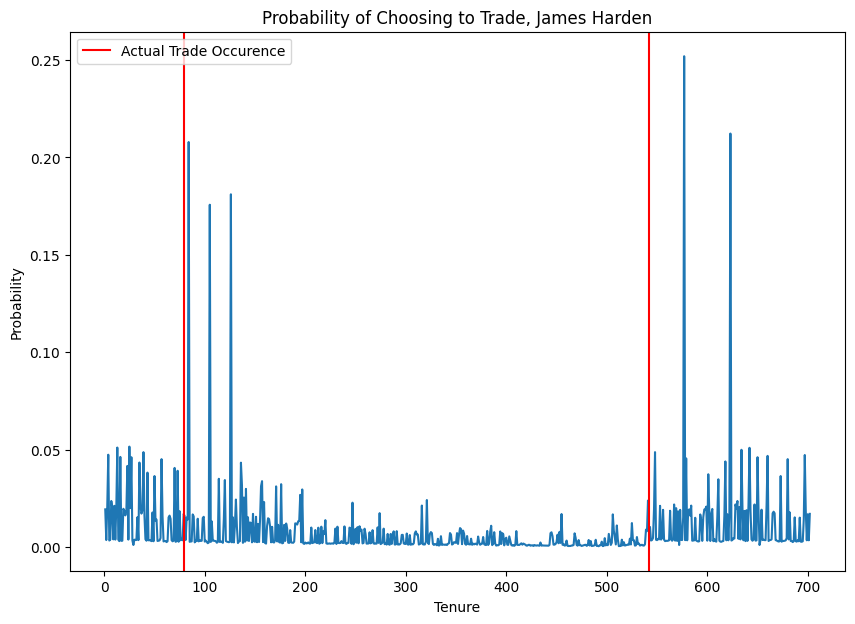

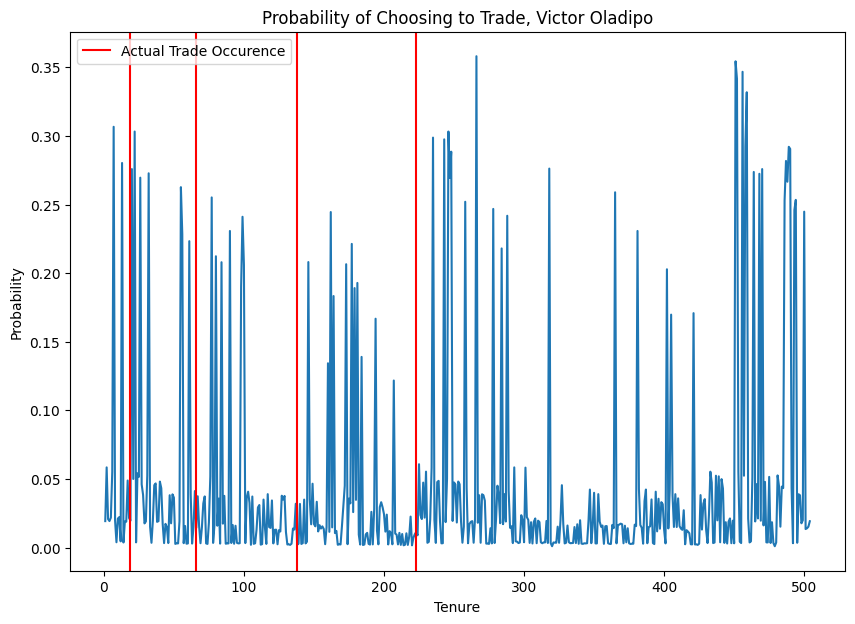

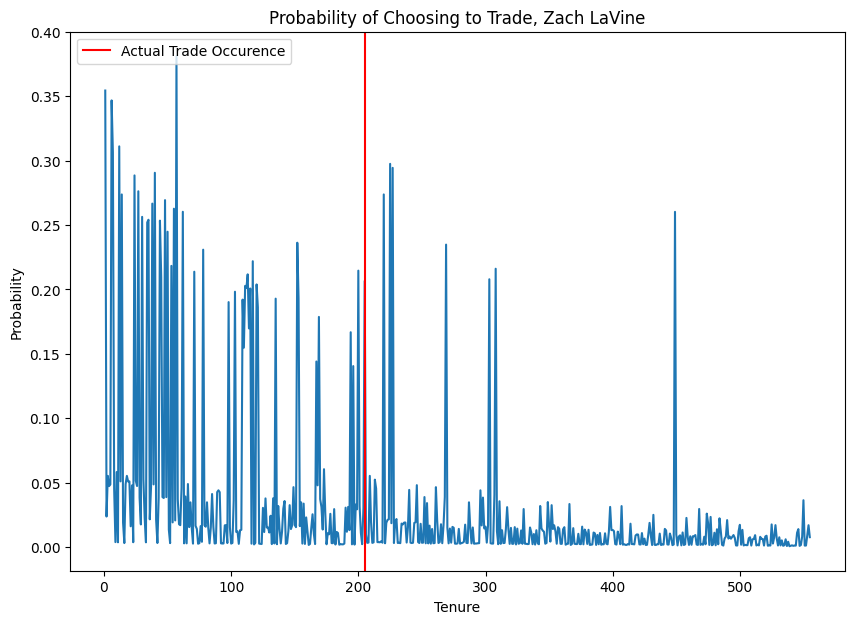

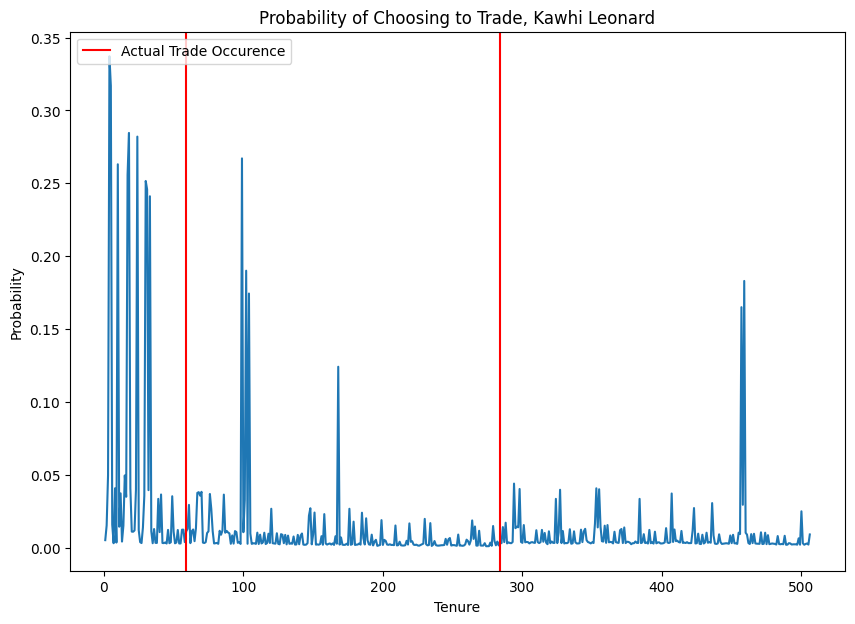

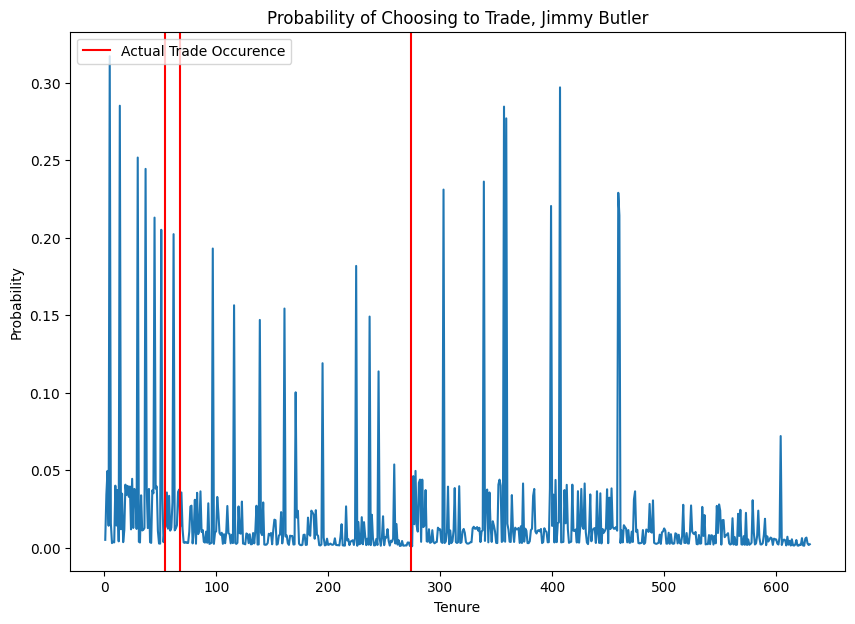

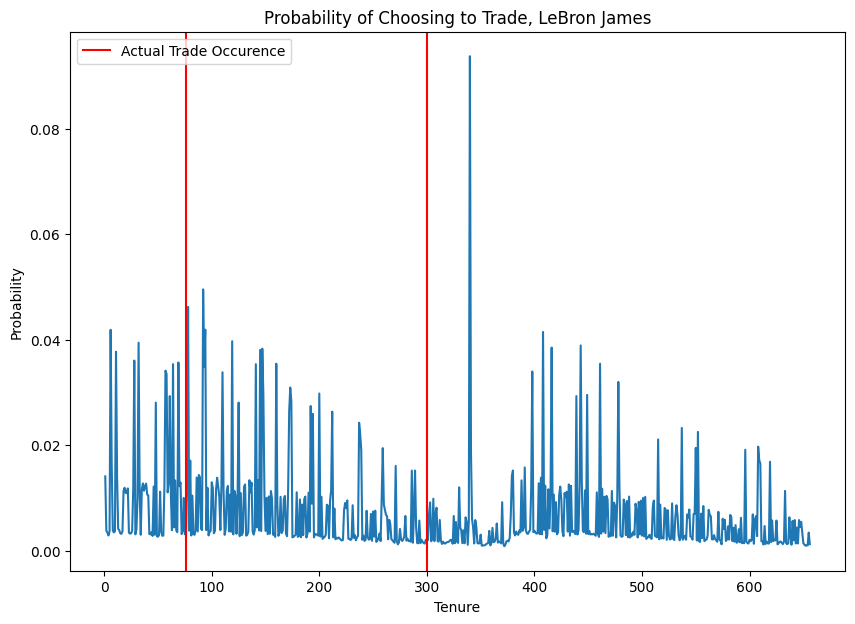

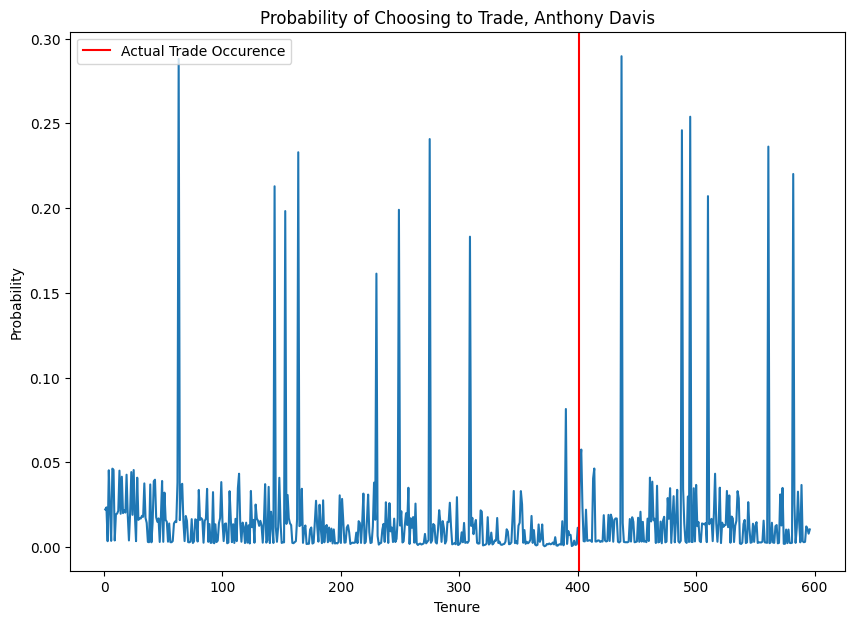

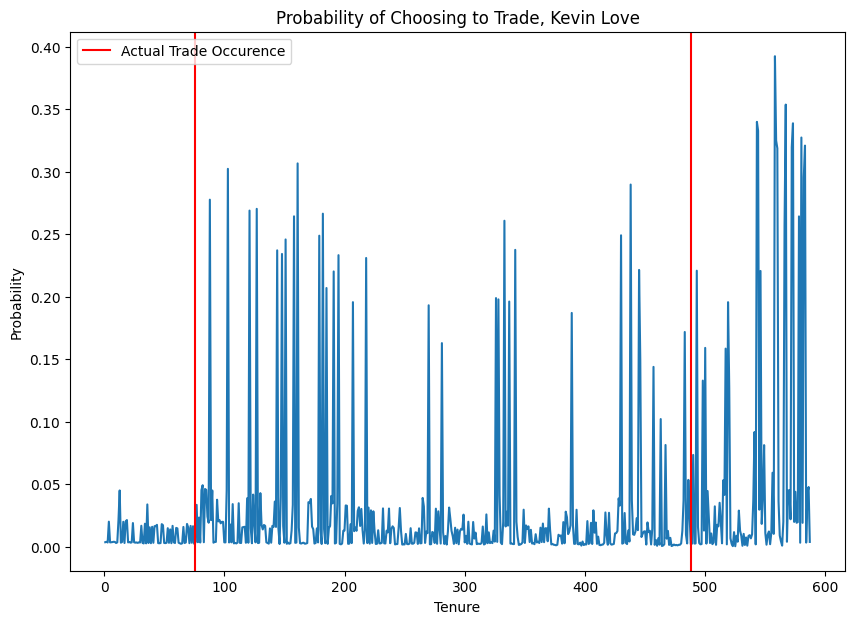

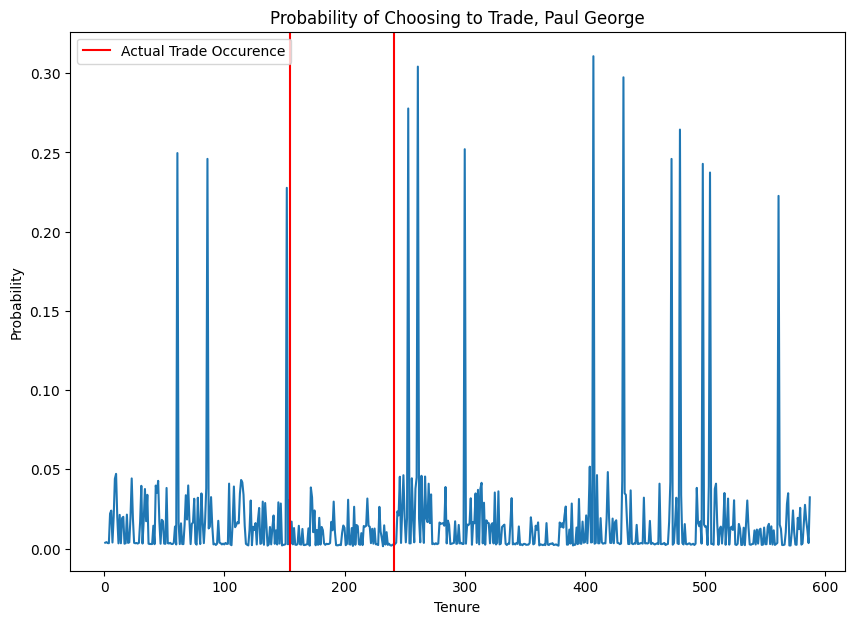

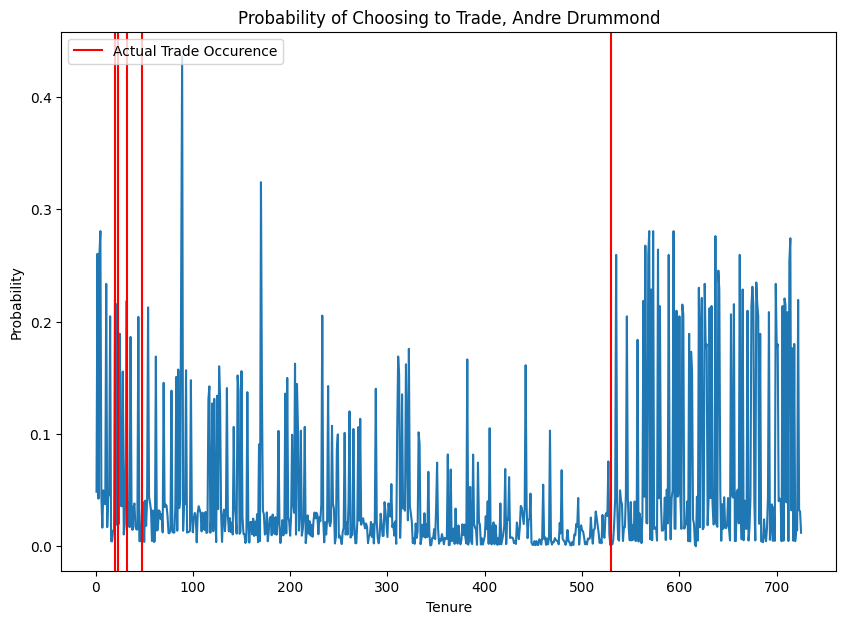

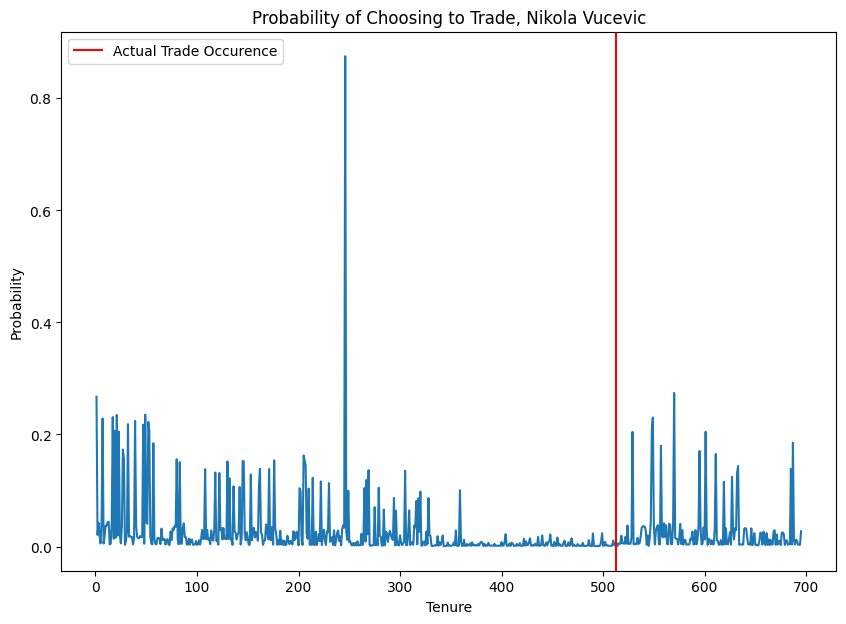

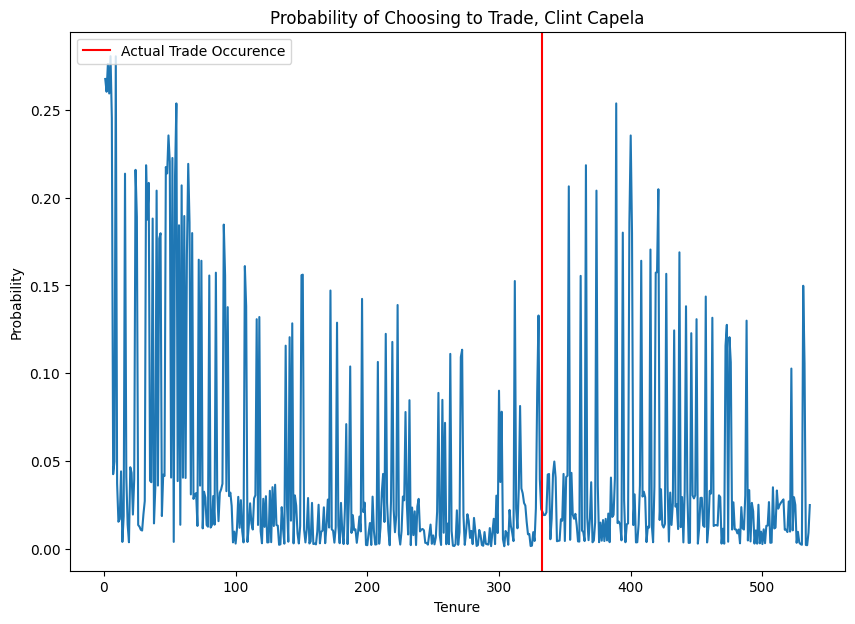

In [355]:
case_study_players = {
    "PG": ["Chris Paul", "Russell Westbrook", "Damian Lillard"],
    "SG": ["James Harden", "Victor Oladipo",  "Zach LaVine"],
    "SF": ["Kawhi Leonard", "Jimmy Butler", "LeBron James"],
    "PF": ["Anthony Davis", "Kevin Love", "Paul George"],
    "C": ["Andre Drummond", "Nikola Vucevic", "Clint Capela"]
}

for pos in case_study_players.keys():
    for player_name in case_study_players[pos]:
        plot_choice_prob_analysis(*get_choice_prob_analysis(pos, player_name), player_name, save=True)